*Técnicas de procesamiento del habla*
#**Reconocimiento de emociones en texto**

### Instalación de dependencias necesarias

In [1]:
!pip install -U transformers
!pip install -U torch
!pip install -U accelerate
!pip install datasets
!pip install bertviz
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 28.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.1
    Uninstalling transformers-4.41.1:
      Successfully uninstalled transformers-4.41.1
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-p

### Importaciones

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset, DatasetDict

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments, AutoModelForSequenceClassification, EarlyStoppingCallback

import torch



### Análisis exploratorio del dataset

In [5]:
df = pd.read_csv('emotion_sentimen_dataset.csv')
df.head()

,Unnamed: 0,text,Emotion
0,0,i seriously hate one subject to death but now ...,hate
1,1,im so full of life i feel appalled,neutral
2,2,i sit here to write i start to dig out my feel...,neutral
3,3,ive been really angry with r and i feel like a...,anger
4,4,i feel suspicious if there is no one outside l...,neutral


In [6]:
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [7]:
classes = df['Emotion'].unique()
classes = classes.tolist()
classes

['hate',
 'neutral',
 'anger',
 'love',
 'worry',
 'relief',
 'happiness',
 'fun',
 'empty',
 'enthusiasm',
 'sadness',
 'surprise',
 'boredom']

In [8]:
# Mapeo de las emociones para etiquetarlas con números
emotion_mapping = {
    'neutral': 0,
    'love': 1,
    'happiness': 2,
    'sadness': 3,
    'relief': 4,
    'hate': 5,
    'anger': 6,
    'fun': 7,
    'enthusiasm': 8,
    'surprise': 9,
    'empty': 10,
    'worry': 11,
    'boredom': 12
}

df['labels'] = df['Emotion'].map(emotion_mapping)

df.head()

,text,Emotion,labels
0,i seriously hate one subject to death but now ...,hate,5
1,im so full of life i feel appalled,neutral,0
2,i sit here to write i start to dig out my feel...,neutral,0
3,ive been really angry with r and i feel like a...,anger,6
4,i feel suspicious if there is no one outside l...,neutral,0


### Visualización de las emociones

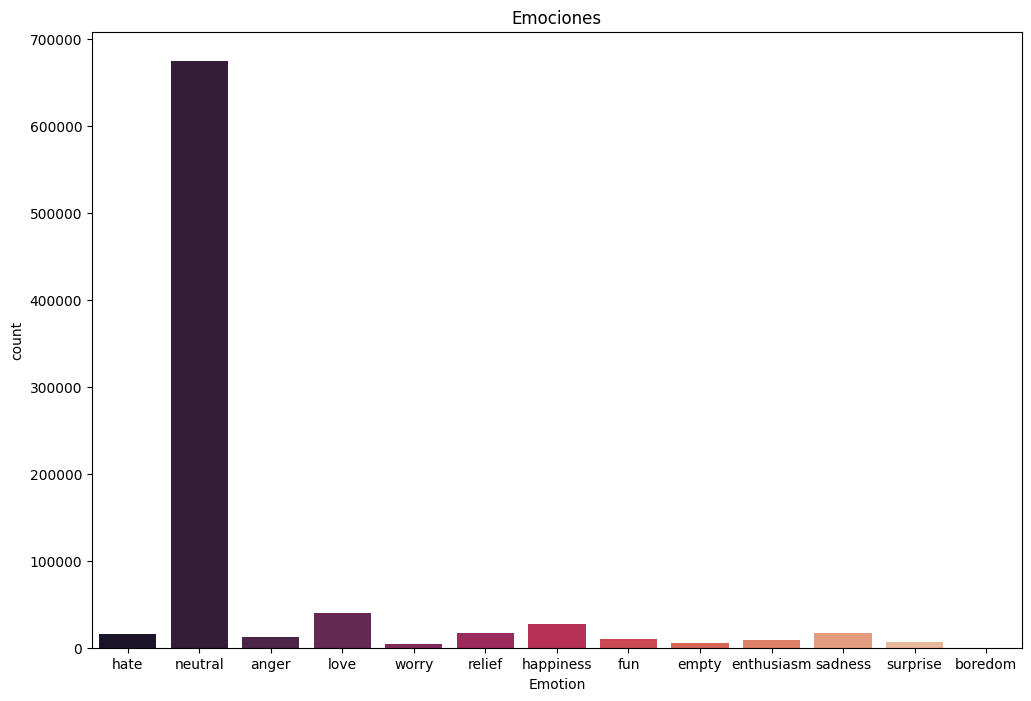

In [9]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Emotion', data=df,hue='Emotion', palette='rocket')
plt.title('Emociones')
plt.show()

### Submuestreo para balancear las clases

In [10]:
# Separar las clases dominantes y minoritarias
majority_class = df[df.Emotion == 'neutral']
minority_classes = df[df.Emotion != 'neutral']

# Submuestrear la clase mayoritaria
majority_class_downsampled = resample(majority_class,
                                      replace=False,  # No reemplazar
                                      n_samples=300,  # Número de muestras deseado para la clase mayoritaria
                                      random_state=42)  # Asegurar reproducibilidad

# Combinar las clases minoritarias y la clase mayoritaria submuestreada
balanced_df = pd.concat([minority_classes, majority_class_downsampled])



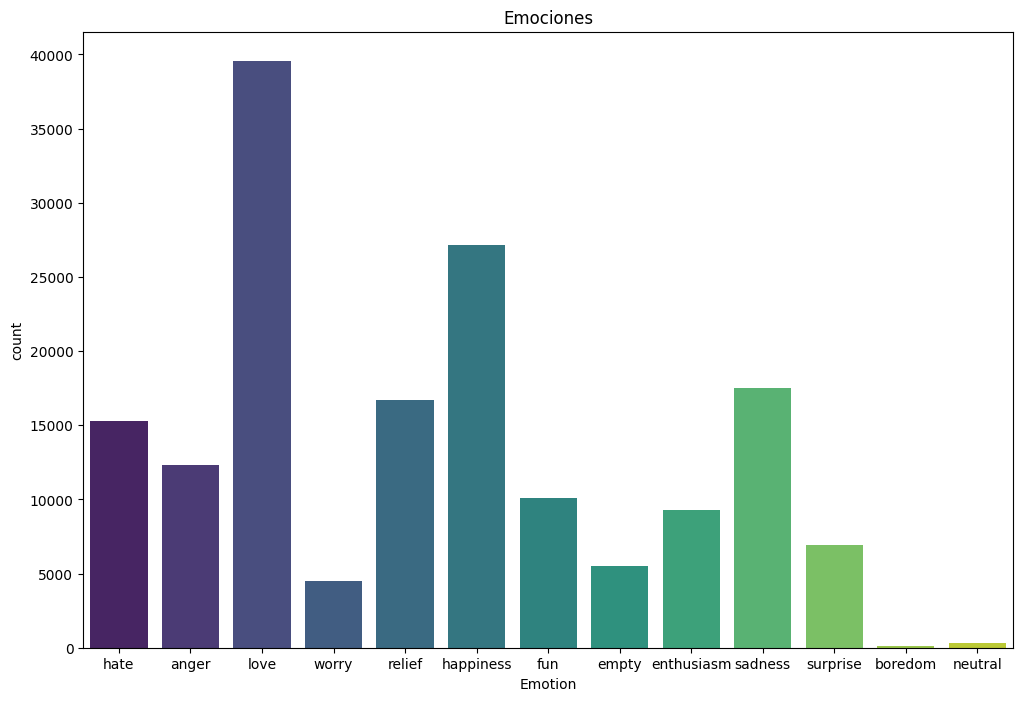

In [11]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Emotion', data=balanced_df,hue='Emotion', palette='viridis')
plt.title('Emociones')
plt.show()

In [12]:
df = balanced_df

In [13]:
df['Words_count'] = df['text'].str.split().apply(len)

In [14]:
df.head()

,text,Emotion,labels,Words_count
0,i seriously hate one subject to death but now ...,hate,5,15
3,ive been really angry with r and i feel like a...,anger,6,19
5,i feel jealous becasue i wanted that kind of l...,love,1,20
7,i finally fell asleep feeling angry useless an...,worry,11,12
15,i feel like they hated me since then,hate,5,8


<Axes: title={'center': 'Words_count'}, xlabel='Emotion'>

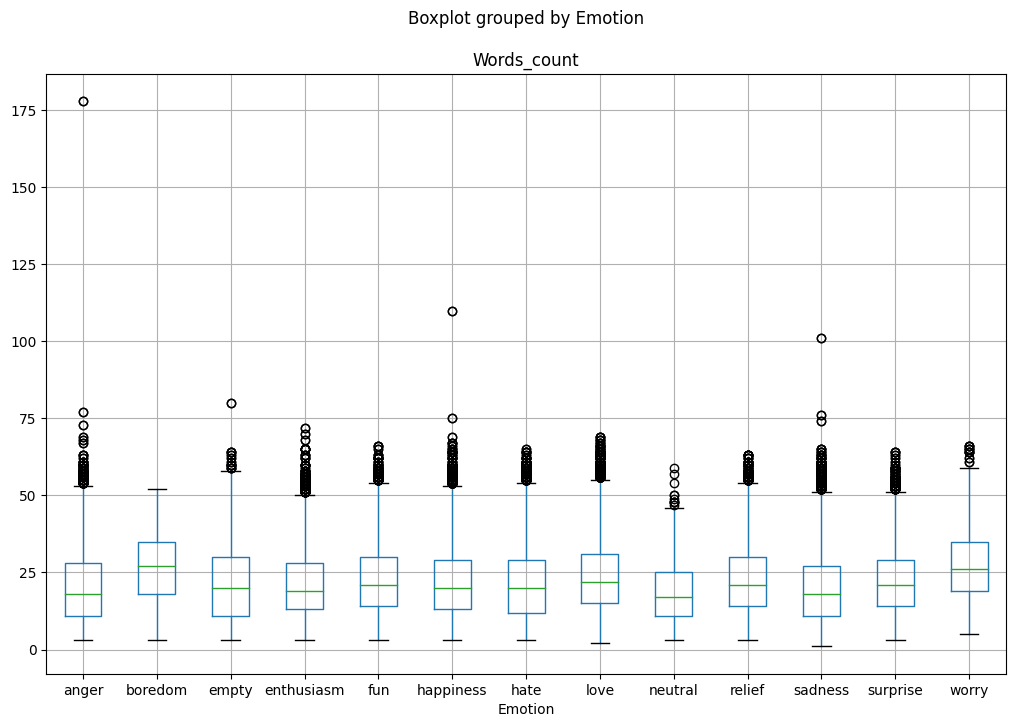

In [15]:

df.boxplot('Words_count', by='Emotion', figsize=(12,8))

### Tokenización

In [16]:
# Checkpoint del modelo pre-entrenado
model_ckpt = 'distilbert-base-uncased'

# Instancia del tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Modelo

In [17]:
# Instancia del modelo
model = AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

### Fine-tuning Transformers

In [18]:
num_labels = len(classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
device

device(type='cuda')

In [20]:


# Specify features and target
X = df['text']
y = df['labels']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Convert splits to DataFrames and reset indices
train_df = pd.DataFrame({'text': X_train, 'labels': y_train}).reset_index(drop=True)
val_df = pd.DataFrame({'text': X_val, 'labels': y_val}).reset_index(drop=True)
test_df = pd.DataFrame({'text': X_test, 'labels': y_test}).reset_index(drop=True)

# Convert DataFrames to Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples['text'], padding=True, truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True, batch_size=None)
val_dataset = val_dataset.map(tokenize_function, batched=True, batch_size=None)
test_dataset = test_dataset.map(tokenize_function, batched=True, batch_size=None)


Map:   0%|          | 0/99189 [00:00<?, ? examples/s]

Map:   0%|          | 0/33064 [00:00<?, ? examples/s]

Map:   0%|          | 0/33064 [00:00<?, ? examples/s]

In [21]:
train_dataset

Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 99189
})

In [22]:
batch_size = 4
model_name = 'distilbert-finetuned-emotion'

training_args = TrainingArguments(output_dir = model_name,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_eval_batch_size = batch_size,
                                  per_device_train_batch_size = batch_size,
                                  gradient_accumulation_steps=16,
                                  weight_decay=0.01,
                                  eval_strategy = 'epoch',
                                  save_strategy = 'epoch',
                                  logging_strategy="epoch",
                                  disable_tqdm=False,
                                  load_best_model_at_end = True,
                                  metric_for_best_model="accuracy",
                                  greater_is_better=True,
                                  save_total_limit=2,)

In [25]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [26]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  tokenizer=tokenizer,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=3)])

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.201800,0.019885,0.995887,0.996182
1,0.011000,0.011677,0.997762,0.997874
2,0.004400,0.009016,0.998427,0.998453
3,0.002200,0.007399,0.998609,0.998645
4,0.001500,0.007367,0.998820,0.998846


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.201800,0.019885,0.995887,0.996182
1,0.011000,0.011677,0.997762,0.997874
2,0.004400,0.009016,0.998427,0.998453
3,0.002200,0.007399,0.998609,0.998645
4,0.001500,0.007367,0.998820,0.998846
5,0.000700,0.008090,0.998367,0.998309


In [ ]:
preds_outputs = trainer.predict(test_dataset)
preds_outputs.metrics

In [ ]:
y_preds = np.argmax(preds_outputs.predictions, axis=1)
y_true = test_dataset[:]['labels']

In [ ]:
print(classes)
print(classification_report(y_true, y_preds))

In [ ]:
predictions = pd.DataFrame()

In [ ]:
predictions['Prediction'] = y_preds

In [ ]:
predictions['Actual'] = y_true

In [ ]:
predictions['Text'] = test_dataset['text']

In [ ]:
predictions.sample(55)

### Guardando el modelo

In [ ]:
model.save_pretrained('/content/drive/MyDrive/emotions_model')
tokenizer.save_pretrained('/content/drive/MyDrive/emotions_model')

In [ ]:
emotions = {
  0: 'neutral😐',
    1:'love😍' ,
    2:'happiness😂' ,
    3:'sadness 😭' ,
    4: 'relief 😌',
    5: 'hate 😠',
    6: 'anger 😡',
    7: 'fun 🥳',
    8: 'enthusiasm 😏',
    9: 'surprise 😦',
    10: 'empty 😑',
    11: 'worry 😟',
    12: 'boredom 🥱'
}

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Ruta al modelo y al tokenizador guardados en Google Drive
model_path = '/content/drive/MyDrive/emotions_model'

# Cargar el modelo y el tokenizador desde la misma ruta
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Ejemplo de texto de entrada
text = "i hate that"

# Tokenizar el texto
inputs = tokenizer(text, return_tensors='pt')

# Pasar los tokens al modelo para obtener las predicciones
outputs = model(**inputs)
logits = outputs.logits

# Convertir las logits en probabilidades
probabilities = torch.nn.functional.softmax(logits, dim=-1)

# Obtener la etiqueta predicha
predicted_label = torch.argmax(probabilities, dim=-1)

print(f"Emoción: {emotions[predicted_label.item()]}")